In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns

# Set up
participants = ['OY', 'SX', 'SM', 'ML']
save_fig = True

# Manage path
cur_dir = os.getcwd()
project_dir = os.path.dirname(os.path.dirname(cur_dir))
out_dir = os.path.join(cur_dir, 's2_plot_group')
data_dir = os.path.join(project_dir, 'data', 'uniLoc')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Define a function to format the elements
def format_element(x):
    return float(f"{x[0][0]:.5f}")


In [3]:
# Initialize lists to store data
all_ses = ['A', 'V']
n_sub = len(participants)
n_ses = len(all_ses)
n_level = 4  # Assuming 4 levels as per the given data
n_rep = 30  # Assuming 30 repetitions as per the given data

# Initialize numpy arrays with the correct dimensions
loc = np.zeros((n_sub, n_level))
est = np.zeros((n_sub, n_ses, n_level, n_rep))
err = np.zeros((n_sub, n_ses, n_level, n_rep))
estMu = np.zeros((n_sub, n_ses, n_level))
estSD = np.zeros((n_sub, n_ses, n_level))
conf = np.zeros((n_sub, n_ses, n_level, n_rep))
act_point = np.zeros((n_sub, n_ses, n_level, n_rep))
max_point = np.zeros((n_sub, n_ses, n_level, n_rep))

# Load data for each participant
for i, sub in enumerate(participants):
    for j, session in enumerate(all_ses):
        file_path = os.path.join(data_dir, f'uniLoc_sub-{sub}_ses-{session}.mat')
        if os.path.exists(file_path):
            data = loadmat(file_path)  # Use loadmat to load .mat file
            ExpInfo = np.squeeze(data["ExpInfo"])
            sortedResp = np.squeeze(data['sortedResp'])

            nRep = int(ExpInfo['nRep'].squeeze())
            nLevel = int(ExpInfo['nLevel'].squeeze())

            # target_cm is the true location of the target
            temp_loc = np.array(np.reshape(np.vectorize(format_element)(sortedResp['target_cm']), (nLevel, nRep)))
            loc[i, :] = temp_loc[:, 0]  # Only take the first repetition because locations are the same for all

            # localization estimates data
            temp_est = np.array(np.reshape(np.vectorize(format_element)(sortedResp['response_cm']), (nLevel, nRep)))
            est[i, j, :, :] = temp_est

            # Calculate error
            temp_err = temp_est - temp_loc
            err[i, j, :, :] = temp_err

            # Calculate mean and standard deviation of estimates
            estMu[i, j, :] = np.mean(temp_est, axis=1)
            estSD[i, j, :] = np.std(temp_est.astype(float), axis=1)

            # Confidence data
            temp_conf = np.array(np.reshape(np.vectorize(format_element)(sortedResp['conf_radius_cm']), (nLevel, nRep)))
            conf[i, j, :, :] = temp_conf

            # points
            temp_point = np.array(np.reshape(np.vectorize(format_element)(sortedResp['point']), (nLevel, nRep)))
            temp_maxPt = np.array(np.reshape(np.vectorize(format_element)(sortedResp['maxPtPossible']), (nLevel, nRep)))
            act_point[i, j, :, :] = temp_point
            max_point[i, j, :, :] = temp_maxPt

        else:
            print(f"File {file_path} not found.")


## Evaluate performance 

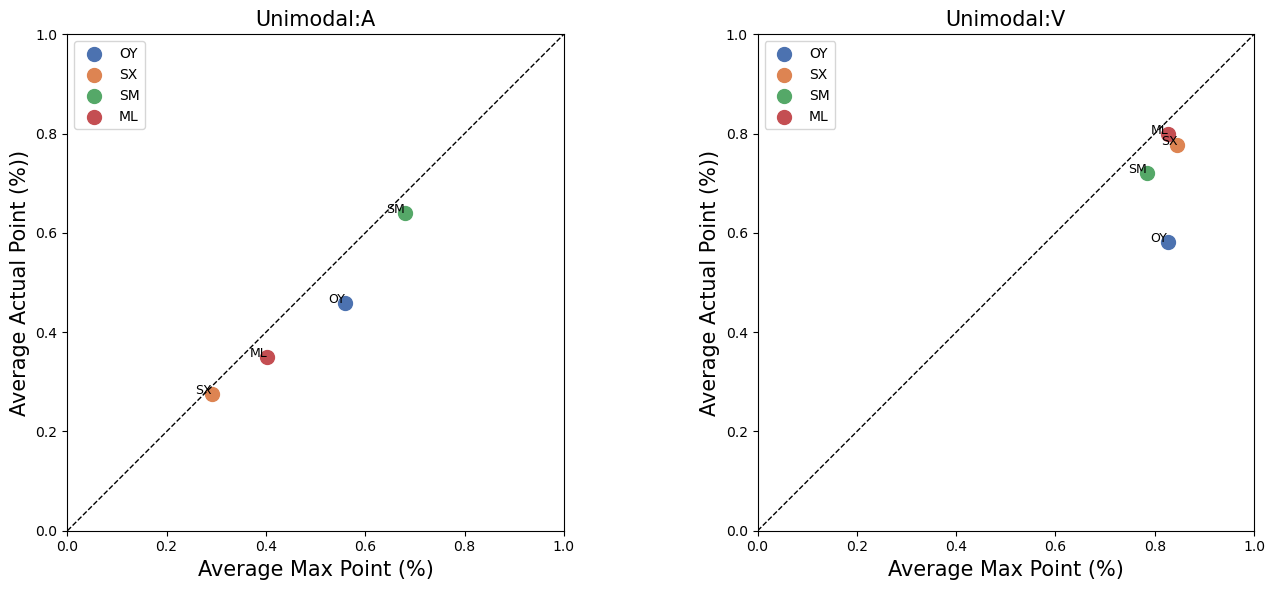

In [4]:
plt.figure(figsize=(14, 6))
fontSZ = 15
titleSZ = 15

# Define colors for each participant using seaborn's "deep" palette
colors = sns.color_palette("deep", len(participants))

# Iterate over sessions
for j, session in enumerate(all_ses):
    avg_max_point = []
    avg_act_point = []
    
    plt.subplot(1, 2, j + 1)
    
    for i, sub in enumerate(participants):
        # Calculate the average max and actual points across all locations for the current session
        avg_max_point.append(np.mean(max_point[i, j, :]))
        avg_act_point.append(np.mean(act_point[i, j, :]))
        
        # Plot each data point with a label and color
        plt.scatter(avg_max_point[-1], avg_act_point[-1], label=sub, color=colors[i], s=100)  # Increase size with s=100
        plt.text(avg_max_point[-1], avg_act_point[-1], sub, fontsize=9, ha='right')
    
    # Add identity line
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    
    # Set plot properties
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Average Max Point (%)', fontsize=fontSZ)
    plt.ylabel('Average Actual Point (%))', fontsize=fontSZ)
    plt.title(f'Unimodal:{session}',fontsize=titleSZ)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')  # Make the subplot square

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'average_points_comparison.png'))
plt.show()

## Correlation between confidence and localization error
### Bin by confidence

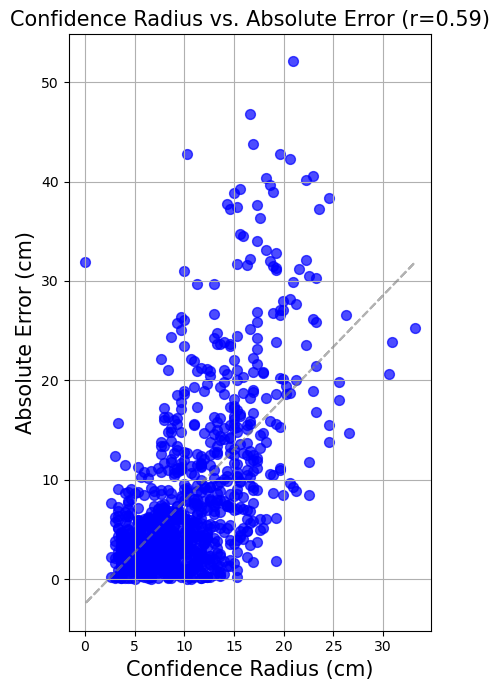

In [5]:
from scipy.stats import linregress

fig, ax = plt.subplots(1, 1, figsize=(7, 7))  # Make the figure square

# Initialize lists to store confidence and corresponding errors
all_conf = []
all_abs_err = []

# Iterate over each subject and session
for j, session in enumerate(all_ses):
    for i in range(n_sub):
        # Flatten the confidence and error arrays for the current subject and session across all locations
        conf_flat = conf[i, j, :, :].flatten()
        abs_err_flat = np.abs(err[i, j, :, :].flatten())

        # Append the data to the lists
        all_conf.extend(conf_flat)
        all_abs_err.extend(abs_err_flat)

# Convert lists to numpy arrays for plotting
all_conf = np.array(all_conf)
all_abs_err = np.array(all_abs_err)

# Scatter plot all data points
ax.scatter(all_conf, all_abs_err, c='blue', s=50, alpha=0.7)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_conf, all_abs_err)
ax.plot(all_conf, slope * all_conf + intercept, color='gray', linestyle='--', alpha=0.6)  # Set alpha to 0.6

# Set plot properties
ax.set_xlabel('Confidence Radius (cm)', fontsize=fontSZ)
ax.set_ylabel('Absolute Error (cm)', fontsize=fontSZ)
ax.set_title(f'Confidence Radius vs. Absolute Error (r={r_value:.2f})', fontsize=titleSZ)
ax.grid(True)
ax.set_aspect('equal', adjustable='box')  # Make the subplot square

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'scatter_conf_err.png'))
plt.show()

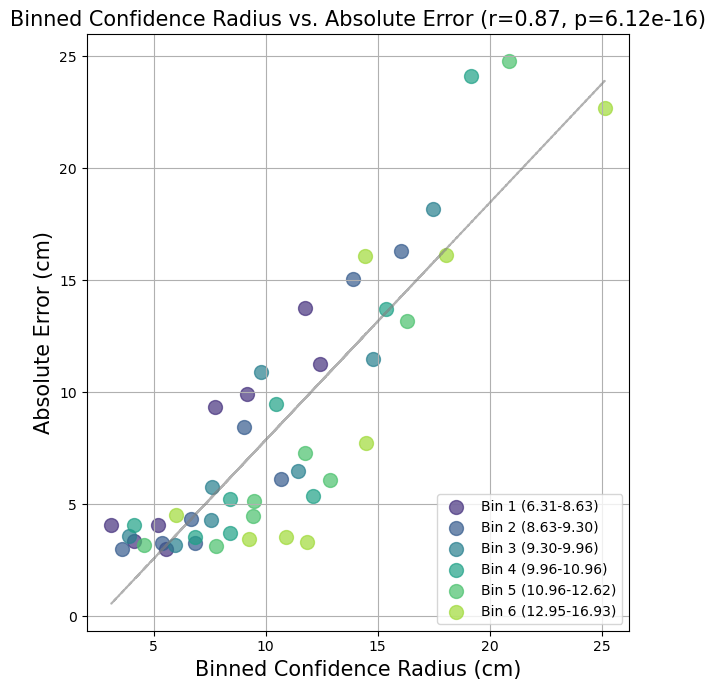

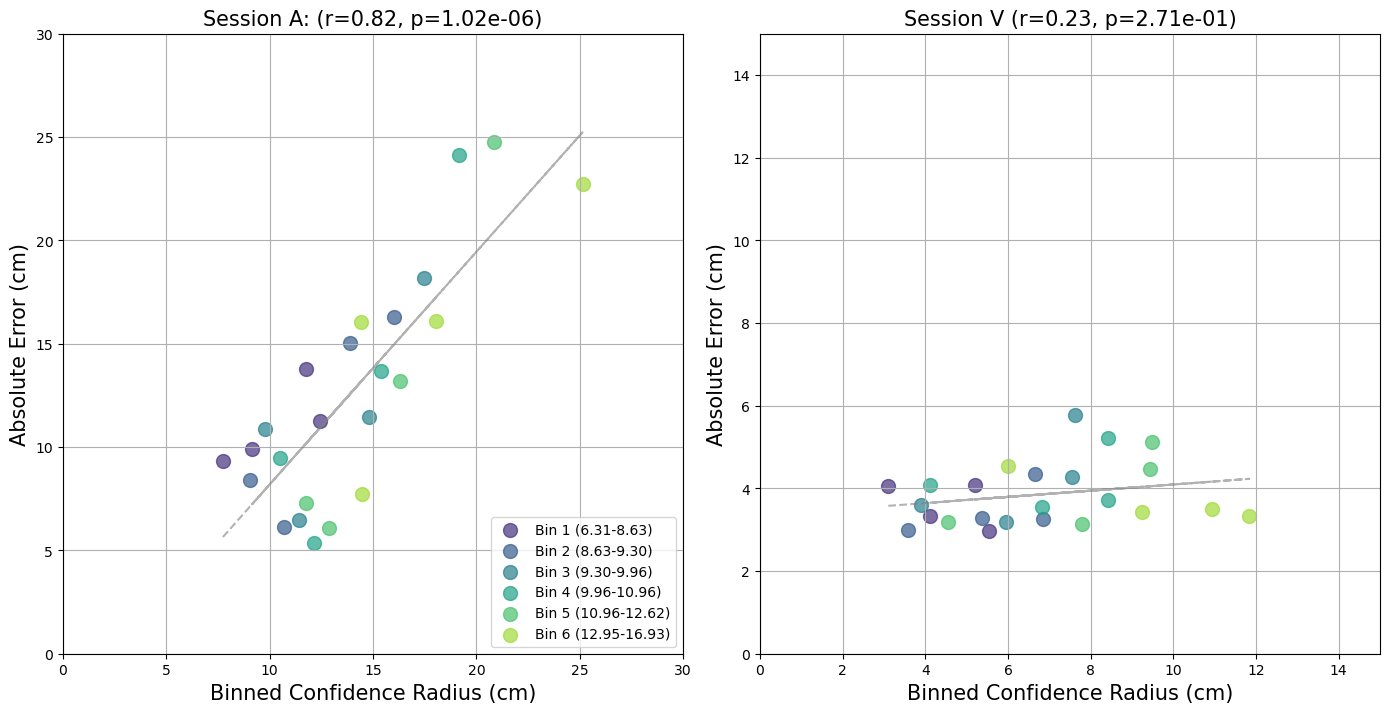

In [14]:
from scipy.stats import linregress
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

n_bin = 6
colors = sns.color_palette("viridis", n_bin)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))  # Make the figure square

# Initialize lists to store binned confidence and corresponding errors
binned_conf = []
binned_err = []
binned_abs_err = []

# Initialize lists to store binned confidence and corresponding errors by session
binned_conf_A = []
binned_abs_err_A = []
binned_conf_V = []
binned_abs_err_V = []

# Initialize list to store bin ranges
bin_ranges = []

# Iterate over each subject and session
for j, session in enumerate(all_ses):
    for i in range(n_sub):
        # Flatten the confidence and error arrays for the current subject and session across all locations
        conf_flat = conf[i, j, :, :].flatten()
        err_flat = err[i, j, :, :].flatten()

        # Get the indices that would sort the confidence values
        sorted_indices = np.argsort(conf_flat)

        # Sort the confidence and error arrays
        conf_sorted = conf_flat[sorted_indices]
        err_sorted = err_flat[sorted_indices]

        # Bin the confidence values into 4 sets with equal number of trials
        bin_size = len(conf_sorted) // n_bin
        for k in range(n_bin):
            start_idx = k * bin_size
            end_idx = (k + 1) * bin_size if k != (n_bin-1) else len(conf_sorted)

            # Calculate the mean confidence and error for the current bin
            mean_conf = np.mean(conf_sorted[start_idx:end_idx])
            mean_err = np.mean(err_sorted[start_idx:end_idx])
            mean_abs_err = np.mean(np.abs(err_sorted[start_idx:end_idx]))

            binned_conf.append(mean_conf)
            binned_err.append(mean_err)
            binned_abs_err.append(mean_abs_err)

            # Store binned data by session
            if session == 'A':
                binned_conf_A.append(mean_conf)
                binned_abs_err_A.append(mean_abs_err)
            else:
                binned_conf_V.append(mean_conf)
                binned_abs_err_V.append(mean_abs_err)

            # Store the bin range
            bin_range = (conf_sorted[start_idx], conf_sorted[end_idx-1])
            bin_ranges.append(bin_range)

# Convert lists to numpy arrays for plotting
binned_conf = np.array(binned_conf)
binned_err = np.array(binned_err)
binned_abs_err = np.array(binned_abs_err)
binned_conf_A = np.array(binned_conf_A)
binned_abs_err_A = np.array(binned_abs_err_A)
binned_conf_V = np.array(binned_conf_V)
binned_abs_err_V = np.array(binned_abs_err_V)

# Plot binned confidence vs absolute error
for k in range(n_bin):
    ax.scatter(binned_conf[k::n_bin], binned_abs_err[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1} ({bin_ranges[k][0]:.2f}-{bin_ranges[k][1]:.2f})')
slope, intercept, r_value, p_value, std_err = linregress(binned_conf, binned_abs_err)
ax.plot(binned_conf, slope * binned_conf + intercept, color='gray', linestyle='--', alpha=0.6)  # Set alpha to 0.6
ax.set_xlabel('Binned Confidence Radius (cm)', fontsize=fontSZ)
ax.set_ylabel('Absolute Error (cm)', fontsize=fontSZ)
ax.set_title(f'Binned Confidence Radius vs. Absolute Error (r={r_value:.2f}, p={p_value:.2e})', fontsize=titleSZ)
ax.legend(loc='lower right')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')  # Make the subplot square

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'corr_conf_err.png'))
plt.show()

# Create the second figure with 2 subplots for sessions A and V
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Two subplots side by side
# Plot for session A
for k in range(n_bin):
    axes[0].scatter(binned_conf_A[k::n_bin], binned_abs_err_A[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1} ({bin_ranges[k][0]:.2f}-{bin_ranges[k][1]:.2f})')
slope_A, intercept_A, r_value_A, p_value_A, std_err_A = linregress(binned_conf_A, binned_abs_err_A)
axes[0].plot(binned_conf_A, slope_A * binned_conf_A + intercept_A, color='gray', linestyle='--', alpha=0.6)
axes[0].set_xlabel('Binned Confidence Radius (cm)', fontsize=fontSZ)
axes[0].set_ylabel('Absolute Error (cm)', fontsize=fontSZ)
axes[0].set_xlim(0, 30)
axes[0].set_ylim(0, 30)
axes[0].set_title(f'Session A: (r={r_value_A:.2f}, p={p_value_A:.2e})', fontsize=titleSZ)
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')
axes[0].legend(loc='lower right')

# Plot for session V
for k in range(n_bin):
    axes[1].scatter(binned_conf_V[k::n_bin], binned_abs_err_V[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1} ({bin_ranges[k][0]:.2f}-{bin_ranges[k][1]:.2f})')
slope_V, intercept_V, r_value_V, p_value_V, std_err_V = linregress(binned_conf_V, binned_abs_err_V)
axes[1].plot(binned_conf_V, slope_V * binned_conf_V + intercept_V, color='gray', linestyle='--', alpha=0.6)
axes[1].set_xlabel('Binned Confidence Radius (cm)', fontsize=fontSZ)
axes[1].set_ylabel('Absolute Error (cm)', fontsize=fontSZ)
axes[1].set_xlim(0, 15)
axes[1].set_ylim(0, 15)
axes[1].set_title(f'Session V (r={r_value_V:.2f}, p={p_value_V:.2e})', fontsize=titleSZ)
axes[1].grid(True)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'corr_conf_err_AV.png'))
plt.show()


### Set bin by cross-subject confidence radius


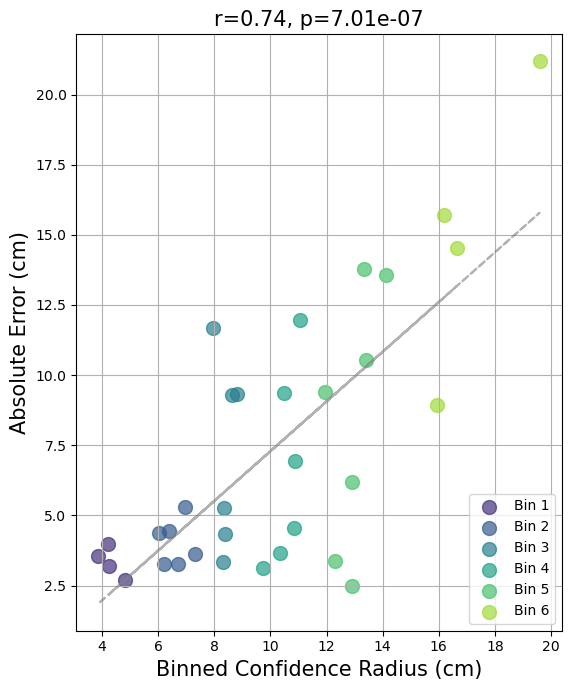

In [7]:
n_bin = 6
colors = sns.color_palette("viridis", n_bin)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))  # Make the figure square

# Flatten all confidence data across subjects and sessions
all_conf_flat = conf.flatten()

# Get the indices that would sort the confidence values
sorted_indices = np.argsort(all_conf_flat)

# Sort the confidence array
all_conf_sorted = all_conf_flat[sorted_indices]

# Bin the confidence values into n_bin sets with equal number of trials, starting from 0.01
bin_size = len(all_conf_sorted) // n_bin
bin_ranges = [0.01] + [all_conf_sorted[i * bin_size] for i in range(1, n_bin)] + [all_conf_sorted[-1]]

# Initialize lists to store binned confidence and corresponding errors
binned_conf = []
binned_err = []
binned_abs_err = []

# Iterate over each subject and session
for j, session in enumerate(all_ses):
    for i in range(n_sub):
        # Flatten the confidence and error arrays for the current subject and session across all locations
        conf_flat = conf[i, j, :, :].flatten()
        err_flat = err[i, j, :, :].flatten()

        # Bin the confidence values based on the bin ranges
        for k in range(n_bin):
            bin_mask = (conf_flat >= bin_ranges[k]) & (conf_flat < bin_ranges[k + 1])
            if np.any(bin_mask):
                # Calculate the mean confidence and error for the current bin
                mean_conf = np.mean(conf_flat[bin_mask])
                mean_err = np.mean(err_flat[bin_mask])
                mean_abs_err = np.mean(np.abs(err_flat[bin_mask]))

                binned_conf.append(mean_conf)
                binned_err.append(mean_err)
                binned_abs_err.append(mean_abs_err)

# Convert lists to numpy arrays for plotting
binned_conf = np.array(binned_conf)
binned_err = np.array(binned_err)
binned_abs_err = np.array(binned_abs_err)
binned_conf_A = np.array(binned_conf_A)
binned_abs_err_A = np.array(binned_abs_err_A)
binned_conf_V = np.array(binned_conf_V)
binned_abs_err_V = np.array(binned_abs_err_V)
# Plot binned confidence vs absolute error
for k in range(n_bin):
    bin_mask = (binned_conf >= bin_ranges[k]) & (binned_conf < bin_ranges[k + 1])
    ax.scatter(binned_conf[bin_mask], binned_abs_err[bin_mask], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1}')
slope, intercept, r_value, p_value, std_err = linregress(binned_conf, binned_abs_err)
ax.plot(binned_conf, slope * binned_conf + intercept, color='gray', linestyle='--', alpha=0.6)  # Set alpha to 0.6
ax.set_xlabel('Binned Confidence Radius (cm)', fontsize=fontSZ)
ax.set_ylabel('Absolute Error (cm)', fontsize=fontSZ)
ax.set_title(f'r={r_value:.2f}, p={p_value:.2e}', fontsize=titleSZ)
ax.legend(loc = 'lower right')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')  # Make the subplot square

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'corr_conf_err.png'))
plt.show()


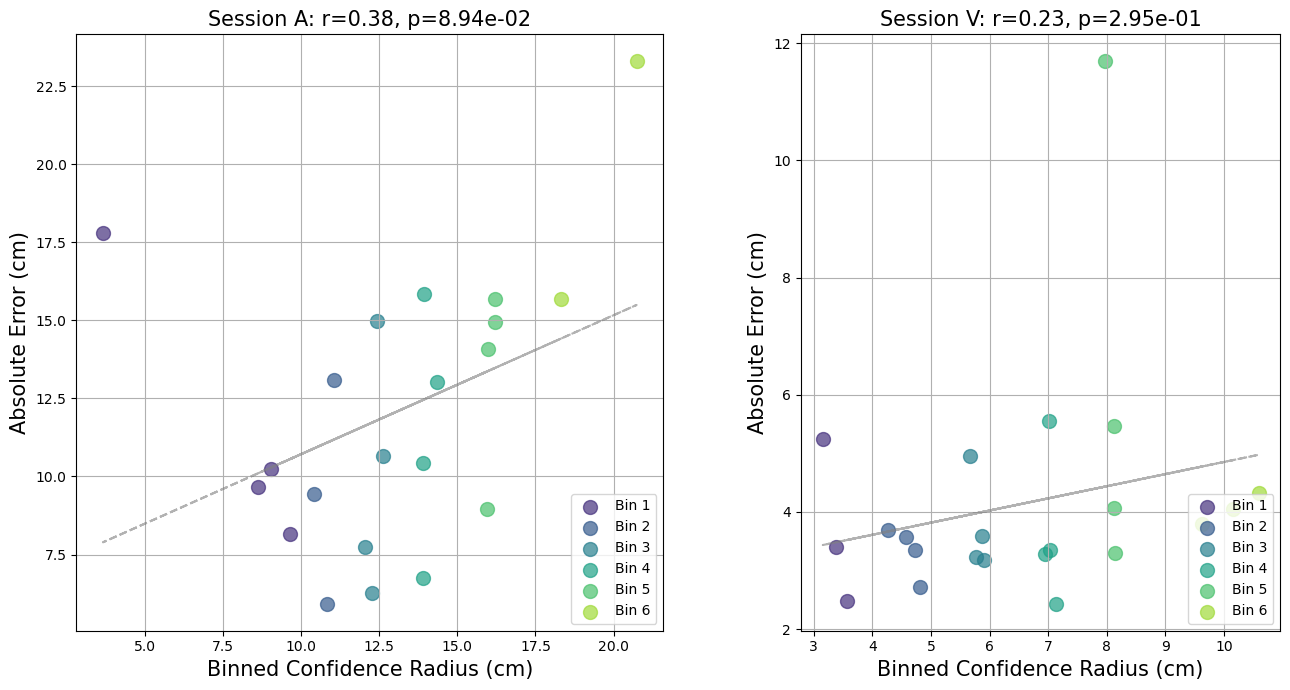

In [8]:
n_bin = 6
colors = sns.color_palette("viridis", n_bin)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Two subplots side by side

# Iterate over each session
for j, session in enumerate(all_ses):
    # Flatten all confidence data across subjects for the current session
    conf_flat = conf[:, j, :, :].flatten()

    # Get the indices that would sort the confidence values
    sorted_indices = np.argsort(conf_flat)

    # Sort the confidence array
    conf_sorted = conf_flat[sorted_indices]

    # Bin the confidence values into n_bin sets with equal number of trials
    bin_size = len(conf_sorted) // n_bin
    bin_ranges = [conf_sorted[i * bin_size] for i in range(n_bin)] + [conf_sorted[-1]]

    # Initialize lists to store binned confidence and corresponding errors
    binned_conf = []
    binned_err = []
    binned_abs_err = []

    # Iterate over each subject
    for i in range(n_sub):
        # Flatten the confidence and error arrays for the current subject and session across all locations
        conf_flat = conf[i, j, :, :].flatten()
        err_flat = err[i, j, :, :].flatten()

        # Bin the confidence values based on the bin ranges
        for k in range(n_bin):
            bin_mask = (conf_flat >= bin_ranges[k]) & (conf_flat < bin_ranges[k + 1])
            if np.any(bin_mask):
                # Calculate the mean confidence and error for the current bin
                mean_conf = np.mean(conf_flat[bin_mask])
                mean_err = np.mean(err_flat[bin_mask])
                mean_abs_err = np.mean(np.abs(err_flat[bin_mask]))

                binned_conf.append(mean_conf)
                binned_err.append(mean_err)
                binned_abs_err.append(mean_abs_err)

    # Convert lists to numpy arrays for plotting
    binned_conf = np.array(binned_conf)
    binned_err = np.array(binned_err)
    binned_abs_err = np.array(binned_abs_err)

    # Plot binned confidence vs absolute error
    for k in range(n_bin):
        bin_mask = (binned_conf >= bin_ranges[k]) & (binned_conf < bin_ranges[k + 1])
        axes[j].scatter(binned_conf[bin_mask], binned_abs_err[bin_mask], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1}')
    slope, intercept, r_value, p_value, std_err = linregress(binned_conf, binned_abs_err)
    axes[j].plot(binned_conf, slope * binned_conf + intercept, color='gray', linestyle='--', alpha=0.6)  # Set alpha to 0.6
    axes[j].set_xlabel('Binned Confidence Radius (cm)', fontsize=fontSZ)
    axes[j].set_ylabel('Absolute Error (cm)', fontsize=fontSZ)
    axes[j].set_title(f'Session {session}: r={r_value:.2f}, p={p_value:.2e}', fontsize=titleSZ)
    axes[j].legend(loc='lower right')
    axes[j].grid(True)
    axes[j].set_aspect('equal', adjustable='box')  # Make the subplot square

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'corr_conf_err_AV.png'))
plt.show()

### Bin by absolute error

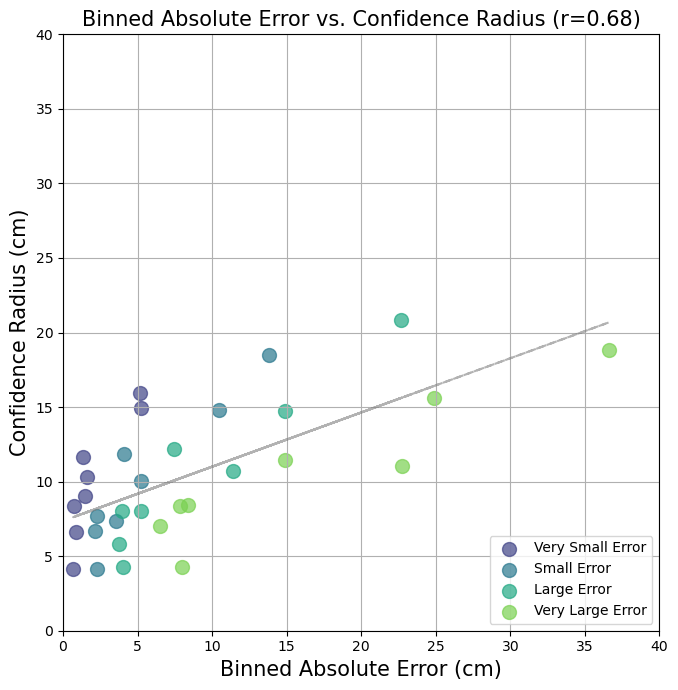

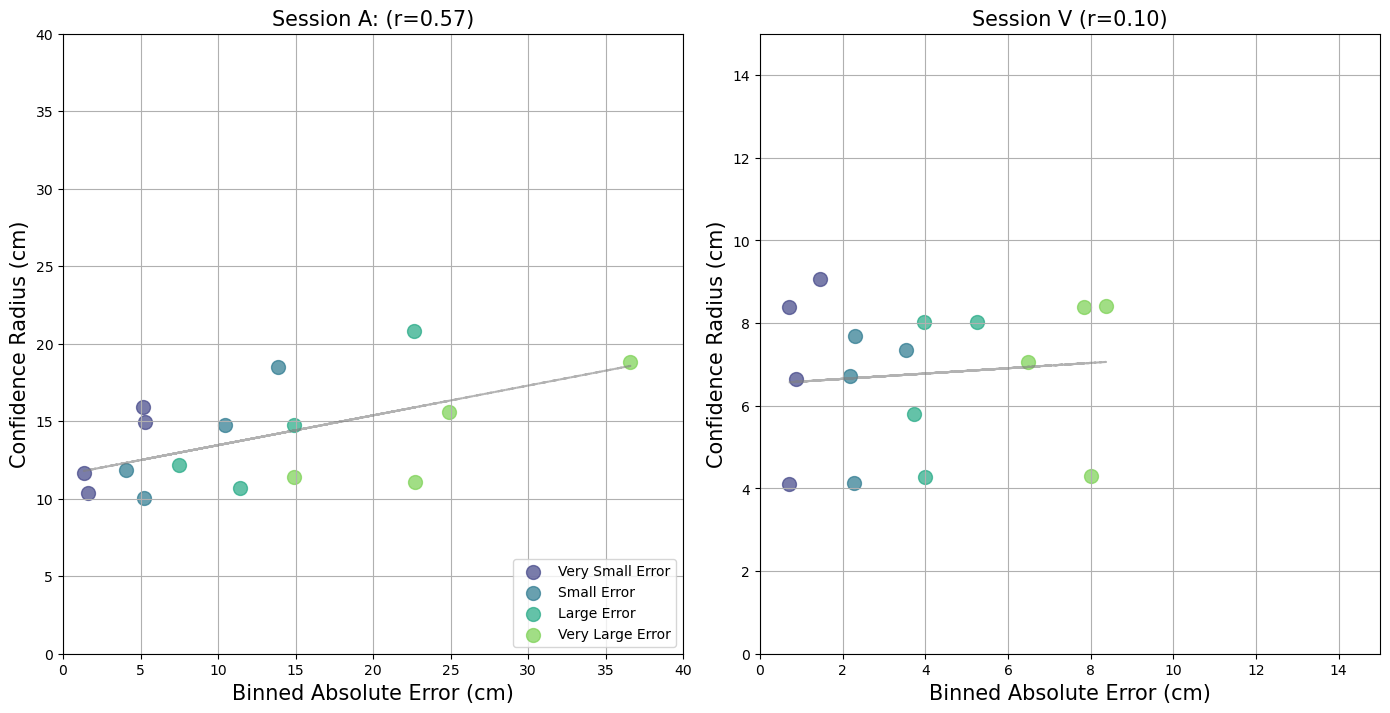

In [9]:
from scipy.stats import linregress

n_bin = 4
colors = sns.color_palette("viridis", n_bin)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))  # Make the figure square

# Initialize lists to store binned confidence and corresponding errors
binned_conf = []
binned_abs_err = []

# Initialize lists to store binned confidence and corresponding errors by session
binned_conf_A = []
binned_abs_err_A = []
binned_conf_V = []
binned_abs_err_V = []

# Iterate over each subject and session
for j, session in enumerate(all_ses):
    for i in range(n_sub):
        # Flatten the confidence and error arrays for the current subject and session across all locations
        conf_flat = conf[i, j, :, :].flatten()
        abs_err_flat = np.abs(err[i, j, :, :].flatten())

        # Get the indices that would sort the absolute error values
        sorted_indices = np.argsort(abs_err_flat)

        # Sort the confidence and absolute error arrays
        conf_sorted = conf_flat[sorted_indices]
        abs_err_sorted = abs_err_flat[sorted_indices]

        # Bin the absolute error values into 4 sets with equal number of trials
        bin_size = len(abs_err_sorted) // n_bin
        for k in range(n_bin):
            start_idx = k * bin_size
            end_idx = (k + 1) * bin_size if k != (n_bin-1) else len(abs_err_sorted)

            # Calculate the mean confidence and absolute error for the current bin
            mean_conf = np.mean(conf_sorted[start_idx:end_idx])
            mean_abs_err = np.mean(abs_err_sorted[start_idx:end_idx])

            binned_conf.append(mean_conf)
            binned_abs_err.append(mean_abs_err)

            # Store binned data by session
            if session == 'A':
                binned_conf_A.append(mean_conf)
                binned_abs_err_A.append(mean_abs_err)
            else:
                binned_conf_V.append(mean_conf)
                binned_abs_err_V.append(mean_abs_err)

# Convert lists to numpy arrays for plotting
binned_conf = np.array(binned_conf)
binned_abs_err = np.array(binned_abs_err)
binned_conf_A = np.array(binned_conf_A)
binned_abs_err_A = np.array(binned_abs_err_A)
binned_conf_V = np.array(binned_conf_V)
binned_abs_err_V = np.array(binned_abs_err_V)

# Plot binned confidence vs absolute error
for k in range(n_bin):
    ax.scatter(binned_abs_err[k::n_bin], binned_conf[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1}')
slope, intercept, r_value, p_value, std_err = linregress(binned_abs_err, binned_conf)
ax.plot(binned_abs_err, slope * binned_abs_err + intercept, color='gray', linestyle='--', alpha=0.6)  # Set alpha to 0.6
ax.set_xlabel('Binned Absolute Error (cm)', fontsize=fontSZ)
ax.set_ylabel('Confidence Radius (cm)', fontsize=fontSZ)
ax.set_title(f'Binned Absolute Error vs. Confidence Radius (r={r_value:.2f})', fontsize=titleSZ)
ax.legend(['Very Small Error', 'Small Error', 'Large Error', 'Very Large Error'], loc='lower right')
ax.grid(True)
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.set_aspect('equal', adjustable='box')  # Make the subplot square

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'corr_abs_err_conf.png'))
plt.show()

# Create the second figure with 2 subplots for sessions A and V
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Two subplots side by side
# Plot for session A
for k in range(n_bin):
    axes[0].scatter(binned_abs_err_A[k::n_bin], binned_conf_A[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1}')
slope_A, intercept_A, r_value_A, p_value_A, std_err_A = linregress(binned_abs_err_A, binned_conf_A)
axes[0].plot(binned_abs_err_A, slope_A * binned_abs_err_A + intercept_A, color='gray', linestyle='--', alpha=0.6)
axes[0].set_xlabel('Binned Absolute Error (cm)', fontsize=fontSZ)
axes[0].set_ylabel('Confidence Radius (cm)', fontsize=fontSZ)
axes[0].set_xlim(0, 40)
axes[0].set_ylim(0, 40)
axes[0].set_title(f'Session A: (r={r_value_A:.2f})', fontsize=titleSZ)
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')
axes[0].legend(['Very Small Error', 'Small Error', 'Large Error', 'Very Large Error'], loc='lower right')

# Plot for session V
for k in range(n_bin):
    axes[1].scatter(binned_abs_err_V[k::n_bin], binned_conf_V[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1}')
slope_V, intercept_V, r_value_V, p_value_V, std_err_V = linregress(binned_abs_err_V, binned_conf_V)
axes[1].plot(binned_abs_err_V, slope_V * binned_abs_err_V + intercept_V, color='gray', linestyle='--', alpha=0.6)
axes[1].set_xlabel('Binned Absolute Error (cm)', fontsize=fontSZ)
axes[1].set_ylabel('Confidence Radius (cm)', fontsize=fontSZ)
axes[1].set_xlim(0, 15)
axes[1].set_ylim(0, 15)
axes[1].set_title(f'Session V (r={r_value_V:.2f})', fontsize=titleSZ)
axes[1].grid(True)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'corr_abs_err_conf_AV.png'))
plt.show()

## Correlation between confidence radius and localization variance

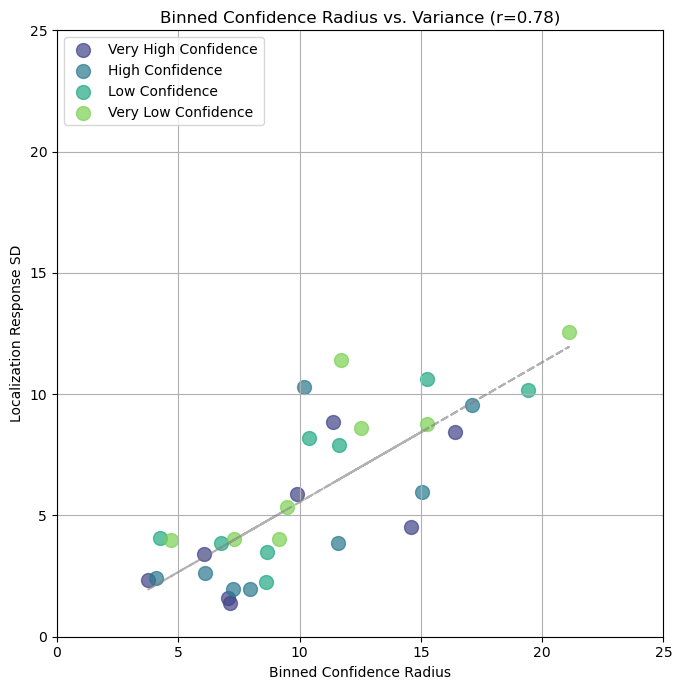

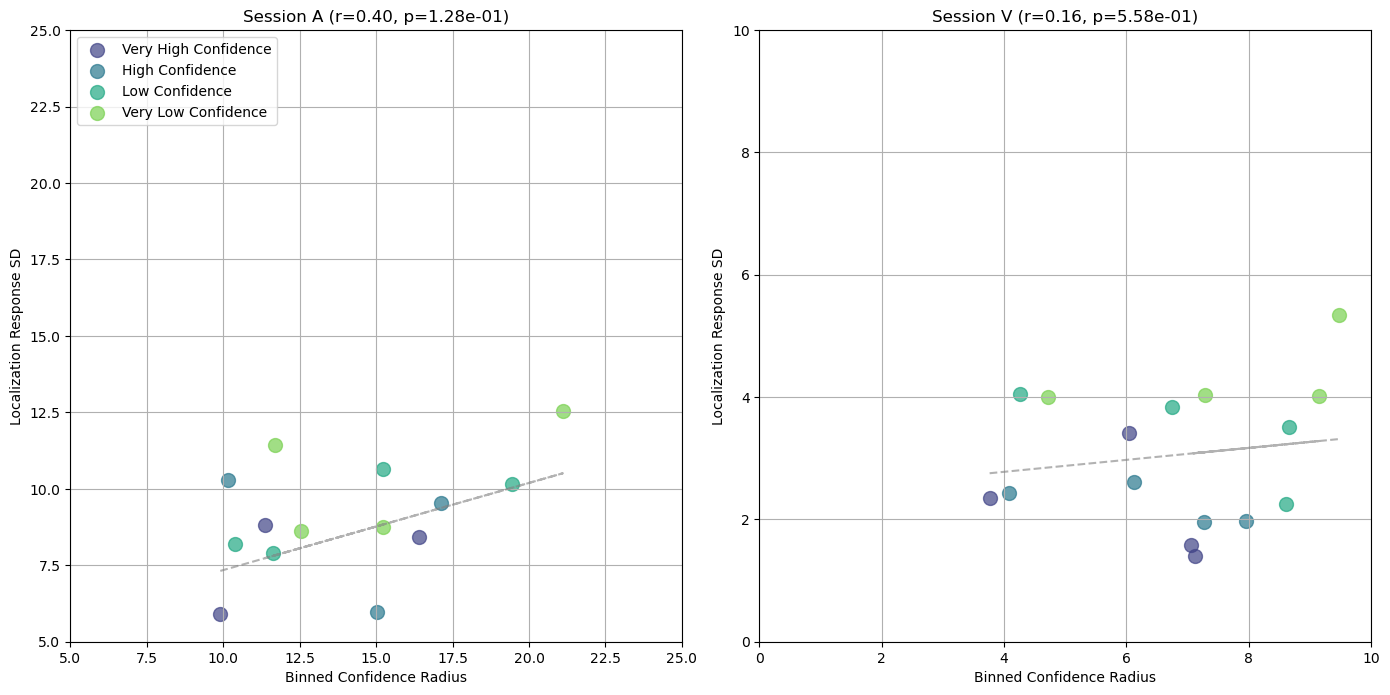

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))  # Make the figure square

n_bin = 4
colors = sns.color_palette("viridis", n_bin)
# Initialize lists to store binned confidence and corresponding variances
binned_conf = []
binned_var = []

# Initialize lists to store binned confidence and corresponding variances by session
binned_conf_A = []
binned_var_A = []
binned_conf_V = []
binned_var_V = []

# Iterate over each subject and session
for j, session in enumerate(all_ses):
    for i in range(n_sub):
        # Flatten the confidence and variance arrays for the current subject and session across all locations
        conf_flat = np.mean(conf[i, j, :, :], axis=-1).flatten()
        var_flat = estSD[i, j, :] .flatten()

        # Get the indices that would sort the confidence values
        sorted_indices = np.argsort(conf_flat)

        # Sort the confidence and variance arrays
        conf_sorted = conf_flat[sorted_indices]
        var_sorted = var_flat[sorted_indices]

        # Bin the confidence values into 4 sets with equal number of trials
        bin_size = len(conf_sorted) // n_bin
        for k in range(n_bin):
            start_idx = k * bin_size
            end_idx = (k + 1) * bin_size if k != (n_bin-1) else len(conf_sorted)

            # Calculate the mean confidence and variance for the current bin
            mean_conf = np.mean(conf_sorted[start_idx:end_idx])
            mean_var = np.mean(var_sorted[start_idx:end_idx])

            binned_conf.append(mean_conf)
            binned_var.append(mean_var)

            # Store binned data by session
            if session == 'A':
                binned_conf_A.append(mean_conf)
                binned_var_A.append(mean_var)
            else:
                binned_conf_V.append(mean_conf)
                binned_var_V.append(mean_var)

# Convert lists to numpy arrays for plotting
binned_conf = np.array(binned_conf)
binned_var = np.array(binned_var)
binned_conf_A = np.array(binned_conf_A)
binned_var_A = np.array(binned_var_A)
binned_conf_V = np.array(binned_conf_V)
binned_var_V = np.array(binned_var_V)
# Plot binned confidence vs variance
for k in range(n_bin):
    ax.scatter(binned_conf[k::n_bin], binned_var[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1}')
slope, intercept, r_value, p_value, std_err = linregress(binned_conf, binned_var)
ax.plot(binned_conf, slope * binned_conf + intercept, color='gray', linestyle='--', alpha=0.6)  # Set alpha to 0.6
ax.set_xlabel('Binned Confidence Radius')
ax.set_ylabel('Localization Response SD')
ax.set_title(f'Binned Confidence Radius vs. Variance (r={r_value:.2f})')
ax.legend(['Very High Confidence', 'High Confidence', 'Low Confidence', 'Very Low Confidence'], loc='upper left')
ax.grid(True)
ax.set_xlim(0, 25)
ax.set_ylim(0, 25)
ax.set_aspect('equal', adjustable='box')
ax.set_aspect('equal', adjustable='box')  # Make the subplot square

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'corr_conf_sd.png'))
plt.show()

# Create the second figure with 2 subplots for sessions A and V
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Two subplots side by side
# Plot for session A
for k in range(n_bin):
    axes[0].scatter(binned_conf_A[k::n_bin], binned_var_A[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1}')
slope_A, intercept_A, r_value_A, p_value_A, std_err_A = linregress(binned_conf_A, binned_var_A)
axes[0].plot(binned_conf_A, slope_A * binned_conf_A + intercept_A, color='gray', linestyle='--', alpha=0.6)
axes[0].set_xlabel('Binned Confidence Radius')
axes[0].set_ylabel('Localization Response SD')
axes[0].set_xlim(5, 25)
axes[0].set_ylim(5, 25)
axes[0].set_title(f'Session A (r={r_value_A:.2f}, p={p_value_A:.2e})')
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')
axes[0].legend(['Very High Confidence', 'High Confidence', 'Low Confidence', 'Very Low Confidence'], loc='upper left')

# Plot for session V
for k in range(n_bin):
    axes[1].scatter(binned_conf_V[k::n_bin], binned_var_V[k::n_bin], c=[colors[k]], s=100, alpha=0.7, label=f'Bin {k+1}')
slope_V, intercept_V, r_value_V, p_value_V, std_err_V = linregress(binned_conf_V, binned_var_V)
axes[1].plot(binned_conf_V, slope_V * binned_conf_V + intercept_V, color='gray', linestyle='--', alpha=0.6)
axes[1].set_xlabel('Binned Confidence Radius')
axes[1].set_ylabel('Localization Response SD')
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)
axes[1].set_title(f'Session V (r={r_value_V:.2f}, p={p_value_V:.2e})')
axes[1].grid(True)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'corr_conf_sd_AV.png'))
plt.show()

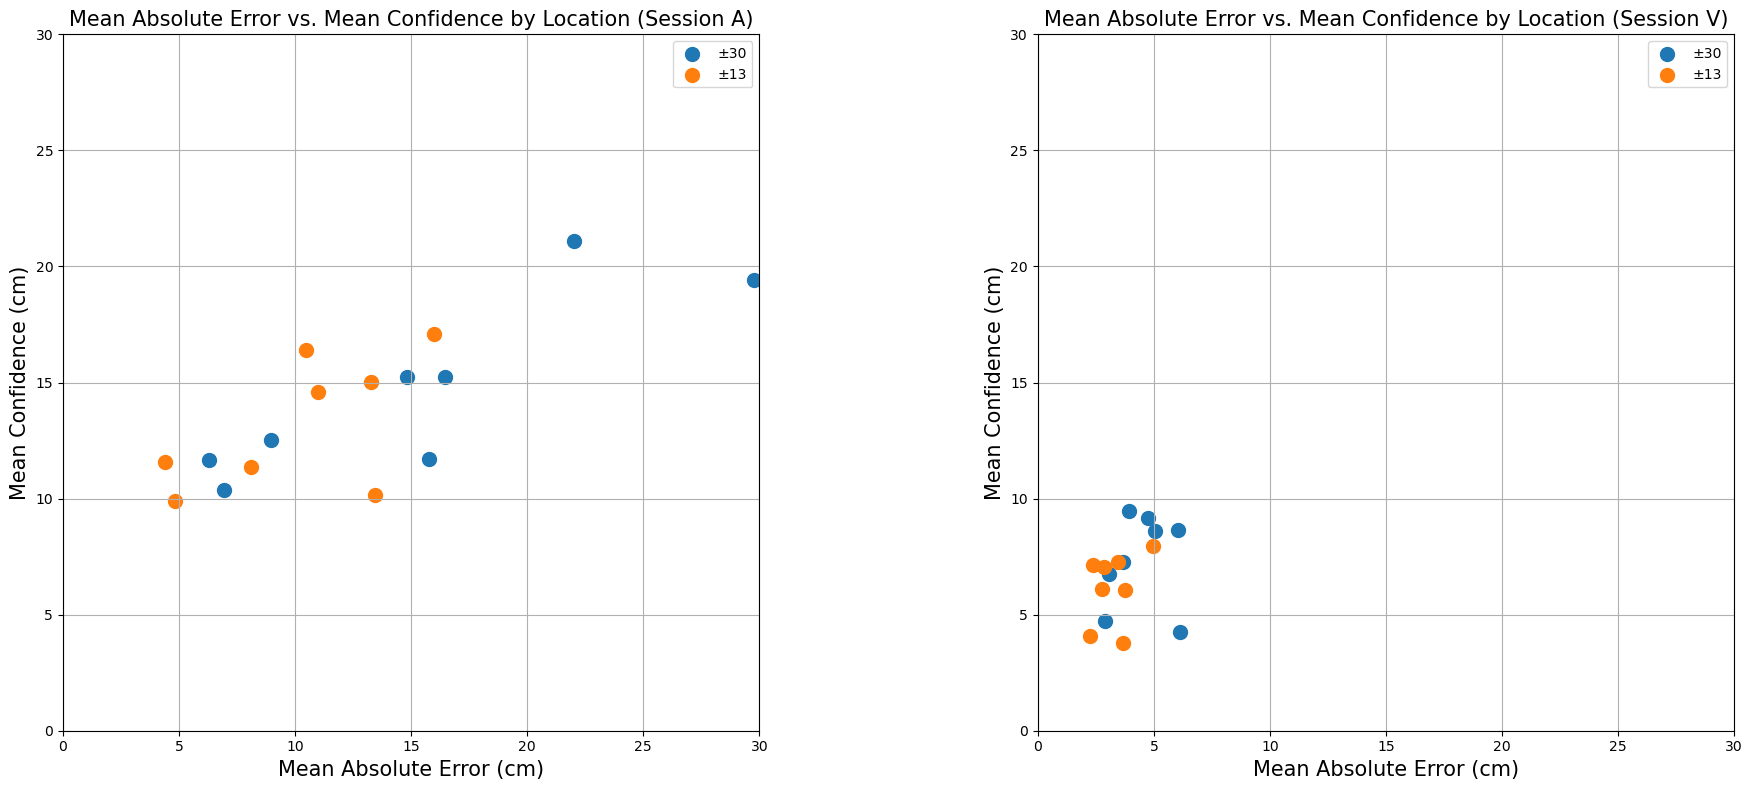

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fontSZ = 15
titleSZ = 15

# Define colors for each location using seaborn's "deep" palette
loc_colors = sns.color_palette("crest", n_level)

# Initialize lists to store mean absolute error and confidence for each location across all participants and sessions
mean_abs_err_loc_all_A = []
mean_conf_loc_all_A = []
mean_abs_err_loc_all_V = []
mean_conf_loc_all_V = []
loc_labels_A = []
loc_labels_V = []

# Iterate over each subject and session
for i, sub in enumerate(participants):
    for j, session in enumerate(all_ses):
        for k in range(n_level):
            # Calculate the mean absolute error and confidence for the current location
            mean_abs_err = np.mean(np.abs(err[i, j, k, :]))
            mean_conf = np.mean(conf[i, j, k, :])
            
            if session == 'A':
                mean_abs_err_loc_all_A.append(mean_abs_err)
                mean_conf_loc_all_A.append(mean_conf)
                if k == 0 or k == 3:
                    loc_labels_A.append('\u00B130')
                elif k == 1 or k == 2:
                    loc_labels_A.append('\u00B113')
            else:
                mean_abs_err_loc_all_V.append(mean_abs_err)
                mean_conf_loc_all_V.append(mean_conf)
                if k == 0 or k == 3:
                    loc_labels_V.append('\u00B130')
                elif k == 1 or k == 2:
                    loc_labels_V.append('\u00B113')

# Scatter plot the mean absolute error and confidence for each location for session A
for label in ['\u00B130', '\u00B113']:
    indices_A = [idx for idx, loc_label in enumerate(loc_labels_A) if loc_label == label]
    axes[0].scatter(np.array(mean_abs_err_loc_all_A)[indices_A], np.array(mean_conf_loc_all_A)[indices_A], 
                    label=label, s=100)

# Scatter plot the mean absolute error and confidence for each location for session V
for label in ['\u00B130', '\u00B113']:
    indices_V = [idx for idx, loc_label in enumerate(loc_labels_V) if loc_label == label]
    axes[1].scatter(np.array(mean_abs_err_loc_all_V)[indices_V], np.array(mean_conf_loc_all_V)[indices_V], 
                    label=label, s=100)

# Set plot properties for session A
axes[0].set_xlim(0, 30)
axes[0].set_ylim(0, 30)
axes[0].set_xlabel('Mean Absolute Error (cm)', fontsize=fontSZ)
axes[0].set_ylabel('Mean Confidence (cm)', fontsize=fontSZ)
axes[0].set_title('Mean Absolute Error vs. Mean Confidence by Location (Session A)', fontsize=titleSZ)
axes[0].legend(loc='upper right')
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

# Set plot properties for session V
axes[1].set_xlim(0, 30)
axes[1].set_ylim(0, 30)
axes[1].set_xlabel('Mean Absolute Error (cm)', fontsize=fontSZ)
axes[1].set_ylabel('Mean Confidence (cm)', fontsize=fontSZ)
axes[1].set_title('Mean Absolute Error vs. Mean Confidence by Location (Session V)', fontsize=titleSZ)
axes[1].legend(loc='upper right')
axes[1].grid(True)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_dir, 'mean_abs_error_confidence_by_location_combined.png'))
plt.show()

In [12]:
print(mean_conf_loc_all_V)

[4.714844333333334, 4.083986, 3.7630213333333336, 4.2610676666666665, 7.2825516666666665, 6.0429683333333335, 6.120442, 6.740234333333334, 9.152994333333334, 7.946614333333335, 7.061196666666666, 8.654947, 9.473958666666668, 7.260416666666667, 7.127604333333332, 8.610677666666668]
